# AUDIO ANALYZER & PLOTTER

Articles to link to:  

Beats solo review:  
https://www.innerfidelity.com/content/monster-beats-dr-dre-solo  
https://www.innerfidelity.com/images/MonsterBeatsSolo.pdf  

Mastering the Mix - EQ Cheat sheet  
https://www.masteringthemix.com/blogs/learn/how-to-get-a-great-tonal-balance-in-your-mix

## Imports

In [1]:
import pdb

import librosa
from librosa.feature import chroma_stft
import librosa.display

import soundfile as sf

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
import seaborn as sns
sns.set(font_scale=2)

In [2]:
# font = {
#     'family': 'Arial',
#     'weight': 'bold',
#     'size': 18
# }
# matplotlib.rc('font', **font)

## AudioAnalyzer Class  

handles the loading and creation of a spectrum dataframe from a single audio file. 

In [131]:
class AudioAnalyzer:
    
    def __init__(self, filename, fft_size=256, input_sr=41000):
        y, sr = librosa.load(filename, sr=input_sr)
        self.y = y
        self.sr = sr
        self.fft_size = fft_size
        
    def change_fft_bin_size(self, size):
        self.fft_size = size
        self.spectrum_analysis()
        
    def spectrum_analysis(self):
        
        self.df = pd.DataFrame(np.abs(librosa.stft(self.y, n_fft=self.fft_size)))
        
        bins = librosa.fft_frequencies(sr=self.sr, n_fft=self.fft_size)
        
        self.df['bins'] = bins / 1000. # divide by 1000 lets us display in kHz
        
        self.df['average_amplitude'] = self.df.mean(axis=1)
        self.df = self.df[['bins', 'average_amplitude']]
        return self.df
    
    def plot_spectrum(self, min_freq=0, max_freq=None, fill=False):
        
        max_freq = max_freq or 20000.
        window = self.df.loc[(self.df.bins * 1000. >= min_freq) & (self.df.bins * 1000. <= max_freq)]
#         TEST
        window[(window.bins > 1) | (window.bins < 3)] = 0.0
#         TEST 
        window.plot(x='bins', y='scaled_amplitude', figsize=(20,8))
        if fill:            
            plt.fill_between(self.df.bins, self.df.average_amplitude)
        
        

## AudioCompare Class  

handles the comparison operations among multiple audio spectrum dataframes (all methods are classmethods only) 

includes:  
- #### get_ratio_df - will calculate and return a new dataframe containing the ratio of amplitudes, Modified / Original
- #### plot_spectrum_group - will take in audio spectrum dataframes and plot them in the same graph with the x axis being the frequency in Hz and the y axis being the average amplitude scaled

In [123]:
class AudioCompare:

    @staticmethod
    def get_max_average(dfs=[]):
        max_average = 0
        for df in dfs:
            cur_max = df.average_amplitude.max()
            max_average = cur_max if cur_max > max_average else max_average
        
        return max_average
    
    @staticmethod
    def scale_amplitudes(dfs=[]):
        max_average = AudioCompare.get_max_average(dfs)
    
        scaled_dfs = []
        for df in dfs:
            averaged = df['average_amplitude']
            df['scaled_amplitude'] = np.interp(averaged, (0., max_average), (0., 1.)) 
            scaled_dfs.append(df)
            
        return scaled_dfs
        
    @classmethod
    def get_ratio_df(cls, original, modified):
        o,m = cls.scale_amplitudes([original,modified])
        orig_scaled = o.scaled_amplitude
        mod_scaled = m.scaled_amplitude
        
        bins = original.bins
        
        ratio_df = pd.DataFrame(mod_scaled / orig_scaled)
        ratio_df['bins'] = bins
        
        curr_scaled = ratio_df.scaled_amplitude
        
        ratio_df.scaled_amplitude = np.interp(curr_scaled, (0., curr_scaled.max()), (0., 1.))
        
        return ratio_df
    
    @classmethod    
    def plot_spectrum_group(cls, dfs=[], title="Comparison of Frequency Amplitudes",
                            xlabel="Frequency (kHz)",
                            ylabel="Normalized Amplitude",                             
                            frange=None,
                            ratio_df=None,
                            legend=["Original", "Modified", "Ratio (Mod:Orig)", "Threshold"],
                            threshold=False
                           ):        
        
        dfs = cls.scale_amplitudes(dfs)
        
        if frange:
            for i, df in enumerate(dfs):
                dfs[i] = df.loc[(df.bins * 1000. >= frange[0]) & (df.bins * 1000. <= frange[1])]
        
        for frame in dfs:
#             frame = frame.iloc[frange[0]:frange[1]]
            plt.plot(frame['bins'], frame['scaled_amplitude'])

        if not ratio_df is None:
            if frange:                
                ratio_df = ratio_df[(ratio_df.bins * 1000. >= frange[0]) & (ratio_df.bins * 1000. <= frange[1])]
            plt.plot(ratio_df['bins'], ratio_df['scaled_amplitude'])
        
        if threshold and frange:
            plt.plot([frange[0] / 1000, frange[1] / 1000], [0.5, 0.5], linestyle="--")
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(legend)
        



# == PROCESS ==

## Load audio files - Original & Modified

In [195]:
original = AudioAnalyzer('ds_test_original.wav', input_sr=48000, fft_size=4096)
modified = AudioAnalyzer('ds_test_bass_modified.wav', input_sr=48000, fft_size=4096)

## Create the DataFrames for each audio file (will be stored in .df for each AudioAnalyzer)

In [196]:
original.spectrum_analysis()
modified.spectrum_analysis()
pass

## Optionally change the fft_bin_size (default value is 256) 
#### (NOTE: will automatically regenerate dataframes when this is run)

(this is not really necessary for basic comparisons, but is available if desired)

In [197]:
original.change_fft_bin_size(48000)
modified.change_fft_bin_size(48000)

## Create a Ratio DataFrame from the Original and Modified DFs

In [198]:
# create a dataframe containing the ration of the modified amplitudes to the original amplitudes
ratio_df = AudioCompare.get_ratio_df(original=original.df, modified=modified.df)

## Plot the average frequency amplitudes (Optionally overaly ratio dataframe)

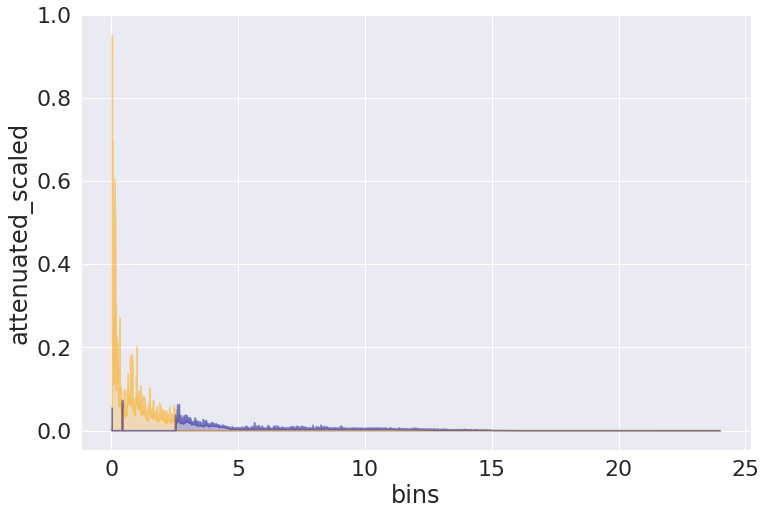

In [243]:
df = modified.df

df['ratio_amplitude'] = ratio_df.scaled_amplitude

df['attenuated_scaled'] = df.scaled_amplitude
df['boosted_scaled'] = df.scaled_amplitude
df.drop(["scaled_amplitude"], axis=1)

df.loc[df.ratio_amplitude < 0.5, ['boosted_scaled'] ] = 0.0
df.loc[df.ratio_amplitude > 0.5, ['attenuated_scaled'] ] = 0.0

# df.loc[(df.bins >= 0.001) & (df.bins <= 0.004)]['average_amplitude'] = 0
# df['ratio_amplitude'] = ratio_df.scaled_amplitude
# df.loc[df.ratio_amplitude < 0.5, ['scaled_amplitude'] ] = 0.0

# df.loc[(df.bins < 1.5)].plot(x='bins', y='boosted_scaled')
# df.loc[(df.bins < 1.5)].plot(x='bins', y='attenuated_scaled')

# plt.plot(df.bins, df.boosted_scaled)
# plt.plot(df.bins, df.attenuated_scaled)

plt.figure(figsize=(12,8))

sns.lineplot(data=df, x="bins", y="boosted_scaled", color='orange', alpha=0.3)
plt.fill_between(df.bins, df.boosted_scaled, color='orange', alpha=0.25)


sns.lineplot(data=df, x="bins", y="attenuated_scaled", color='darkblue', alpha=0.3)
plt.fill_between(df.bins, df.attenuated_scaled, color='darkblue', alpha=0.25)

In [158]:
ratio_df.head()

,scaled_amplitude,bins
0,0.075041,0.000
1,0.111606,0.001
2,0.164541,0.002
3,0.173922,0.003
4,0.188196,0.004


/home/qdizon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/qdizon/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


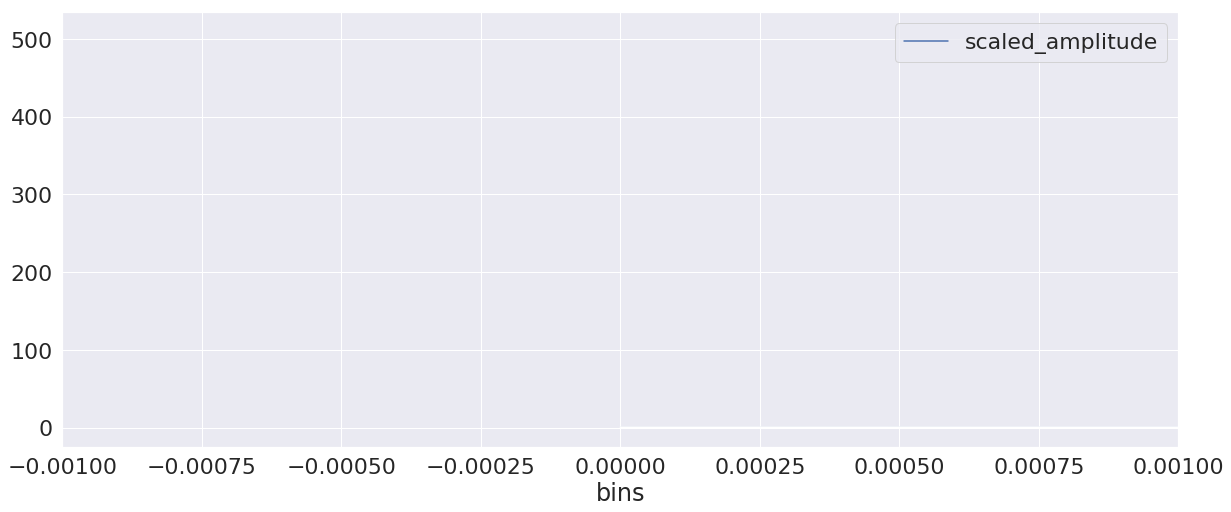

In [138]:
modified.plot_spectrum(min_freq=0, max_freq=4000, fill=True)

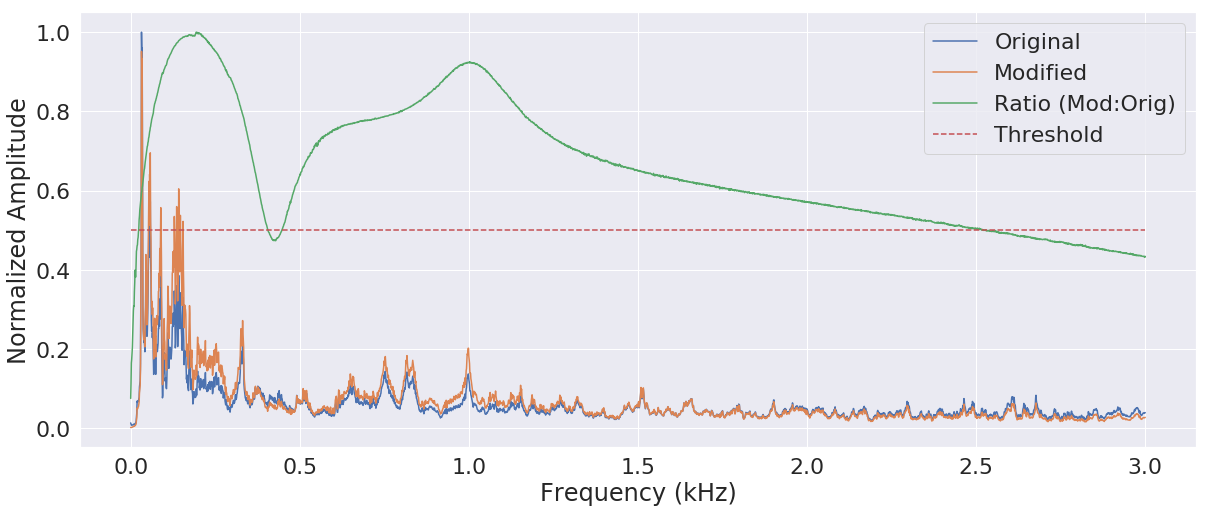

In [118]:
fig = plt.figure(figsize=(20,8))

AudioCompare.plot_spectrum_group(
    dfs=[original.df, modified.df],
    frange=(0,3000),
    ratio_df=ratio_df,
    threshold=True
)
plt.show()

# SIBELIUS TEST


In [10]:
sib_original = AudioAnalyzer('sibelius_original.wav',input_sr=48000, fft_size=4096)
sib_modified = AudioAnalyzer('sibelius_modified.wav',input_sr=48000, fft_size=4096)

In [11]:
sib_original.spectrum_analysis()
sib_modified.spectrum_analysis()
pass

In [12]:
sib_modified.change_fft_bin_size(48000)
sib_original.change_fft_bin_size(48000)

In [13]:
sib_ratio_df = AudioCompare.get_ratio_df(original=sib_original.df, modified=sib_modified.df)

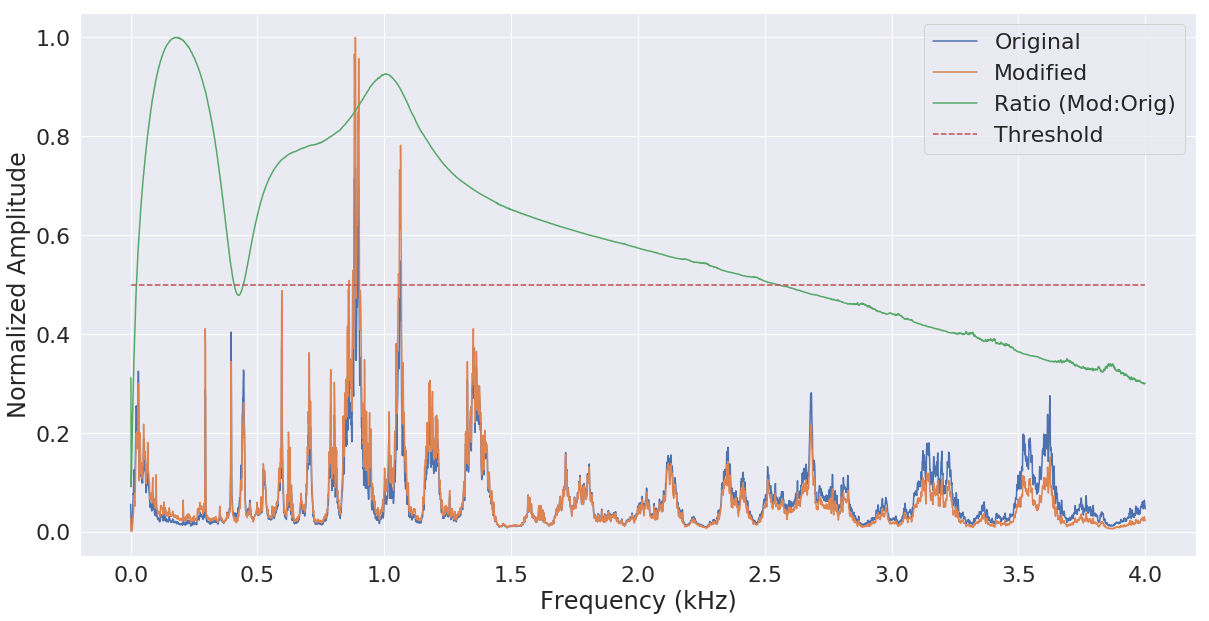

In [14]:
fig = plt.figure(figsize=(20,10))

AudioCompare.plot_spectrum_group(
    dfs=[sib_original.df, sib_modified.df],
    frange=(0,4000),
    ratio_df=sib_ratio_df,
    title="Frequency Amplitudes Comparison - Sibelius Vln. Concerto",
    threshold=True
)

plt.show()